In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
from tensorflow.keras.layers import Add, BatchNormalization, Conv2D, Conv2DTranspose, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda, MaxPool2D, ReLU, Concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import layers


In [3]:
def res_block_simple(inp, stage, substage):    
    filters=inp.shape.as_list()[-1]//4
    conv=Conv2D(filters, 1, activation='relu', use_bias=False, name='res{0}{1}_branch2a'.format(stage, substage))(inp)   
    conv=Conv2D(filters, 3, padding='same', activation='relu', use_bias=False, name='res{0}{1}_branch2b'.format(stage, substage))(conv)
    conv=Conv2D(filters*4, 1, use_bias=False, name='res{0}{1}_branch2c'.format(stage, substage))(conv)    
    add=Add(name='res{0}{1}_'.format(stage, substage))([inp, conv])
    return ReLU(name='res{0}{1}'.format(stage, substage))(add)

def res_block_ext(inp, stage):    
    filters=inp.shape.as_list()[-1]//2
    strds=(2,2)
    if filters==32:
        filters=filters*2
        strds=(1,1)        
    conv=Conv2D(filters, 1, strides=strds, activation='relu', use_bias=False, name='res{0}a_branch2a'.format(stage))(inp)    
    conv=Conv2D(filters, 3, padding='same', activation='relu', use_bias=False, name='res{0}a_branch2b'.format(stage))(conv)     
    conv=Conv2D(filters*4, 1, use_bias=False, name='res{0}a_branch2c'.format(stage))(conv)    
    inp1=Conv2D(filters*4, 1, strides=strds, use_bias=False, name='res{0}a_branch1'.format(stage))(inp)    
    
    add=Add(name='res{0}a_'.format(stage))([conv,inp1])
    return ReLU(name='res{0}a'.format(stage))(add)

def get_res50(inp_shape=(500,500,3)):
    inp=Input(shape=inp_shape)
    conv=Conv2D(64, 7, padding='same', activation='relu', name='conv1')(inp)    
    out=MaxPool2D(strides=2, padding='same', name='pool1')(conv)    
    outputs=[conv]
    
    for num, blocks in enumerate([2,3,5,2]):
        stage=num+2
        out=res_block_ext(out, stage)
        for substage in 'bcdef'[:blocks]:
            out=res_block_simple(out, stage, substage)
        outputs.append(out)
    return Model(inputs=inp,outputs=outputs)

# chanel first version of resnet50

In [3]:
def res_block_simple(inp, stage, substage):    
    filters=inp.shape.as_list()[1]//4
    conv=Conv2D(filters, 1, activation='relu', use_bias=False, data_format='channels_first', name='res{0}{1}_branch2a'.format(stage, substage))(inp)   
    conv=Conv2D(filters, 3, padding='same', activation='relu', use_bias=False, data_format='channels_first', name='res{0}{1}_branch2b'.format(stage, substage))(conv)
    conv=Conv2D(filters*4, 1, use_bias=False, data_format='channels_first', name='res{0}{1}_branch2c'.format(stage, substage))(conv)    
    add=Add(name='res{0}{1}_'.format(stage, substage))([inp, conv])
    return ReLU(name='res{0}{1}'.format(stage, substage))(add)

def res_block_ext(inp, stage): 
    
    filters=inp.shape.as_list()[1]//2
    
    strds=(2,2)
    if filters==32:
        filters=filters*2
        strds=(1,1)        
    conv=Conv2D(filters, 1, strides=strds, activation='relu', use_bias=False, data_format='channels_first', name='res{0}a_branch2a'.format(stage))(inp)    
    conv=Conv2D(filters, 3, padding='same', activation='relu', use_bias=False, data_format='channels_first', name='res{0}a_branch2b'.format(stage))(conv)     
    conv=Conv2D(filters*4, 1, use_bias=False, data_format='channels_first', name='res{0}a_branch2c'.format(stage))(conv)    
    inp1=Conv2D(filters*4, 1, strides=strds, use_bias=False, data_format='channels_first', name='res{0}a_branch1'.format(stage))(inp)    
    
    add=Add(name='res{0}a_'.format(stage))([conv,inp1])
    return ReLU(name='res{0}a'.format(stage))(add)

def get_res50(inp_shape=(500,500,3)):
    inp=Input(shape=inp_shape)
    conv=Conv2D(64, 7, padding='same', activation='relu', data_format='channels_first', name='conv1')(inp)    
    out=MaxPool2D(strides=2, padding='same', data_format='channels_first', name='pool1')(conv)    
    outputs=[conv]
    
    for num, blocks in enumerate([2,3,5,2]):
        stage=num+2
        out=res_block_ext(out, stage)
        for substage in 'bcdef'[:blocks]:
            out=res_block_simple(out, stage, substage)
        outputs.append(out)
    return Model(inputs=inp,outputs=outputs)

In [ ]:
dot_img_file = 'res50_model.png'
tf.keras.utils.plot_model(mod, to_file=dot_img_file, show_shapes=True)

# Outlines branch

In [18]:
# crop like-caffe layer 
class Crop(layers.Layer):
    """centerred cropping of target layer by dimensions of template layer 
    EXAMPLE:
    cropped_lr=Crop(name='cropped_layer')(target, templ)
    """
    def __init__(self, **kwargs):
        super(Crop, self).__init__(**kwargs)       

    
    def compute_output_shape(self, input_shape):
        sh=(input_shape[1][0],input_shape[1][1],input_shape[1][2],input_shape[0][3])
        return sh
    
    
    def call(self, x, trainable=False):
        x_shape = tf.shape(x[0])
        templ_sh= tf.shape(x[1])
        
        offsets = [0, (x_shape[1] - templ_sh[1]) // 2, (x_shape[2] - templ_sh[2]) // 2, 0]
        size = [-1, templ_sh[1], templ_sh[2], x_shape[3]]        
        
        x_crop = tf.slice(x[0], offsets, size)
        x_crop.set_shape(self.compute_output_shape([x[0].shape, x[1].shape]))
        return x_crop

def DSN_deconv(lr, inp_lr):
    lr_name=lr.name.split('/')[0]
    lr_num=[int(s) for s in lr_name if s.isdigit()][0]    
    con=Conv2D(1,1, name='score-dsn{0}'.format(lr_num))(lr)
    if lr_num>1:
        st=2**(lr_num-1)
        ks=st*2
        con=Conv2DTranspose(1,ks,(st,st), name='upsample_{0}'.format(st))(con)
    con=Crop(name='crop{0}'.format(lr_num))([con, inp_lr])
    return con     

def get_outlines_net(res_inp, res_outp):
    DSN=[DSN_deconv(lr, res_inp) for lr in res_outp] 
    
    con1=Concatenate(name="concat1")(DSN[:-1])
    con1=Conv2D(1,1, name='new-score-weighting1')(con1)
    con1=Activation('sigmoid', name='sigmoid-fuse_scale_2.0')(con1)
    
    con2=Concatenate(name="concat3")(DSN[1:])
    con2=Conv2D(1,1, name='new-score-weighting3')(con2)
    con2=Activation('sigmoid', name='sigmoid-fuse_scale_0.5')(con2)
    return [con1, con2]

In [5]:
# res50=get_res50()
res50=get_res50(inp_shape=(None,None,3))
res_inp=res50.inputs
res_out=res50.output
outlines=get_outlines_net(res_inp[0], res_out)
outl_model=Model(res_inp, outlines)

# assigning weights from caffe model

In [ ]:
for lr in outl_model.weights:
    print('{0:20} {1}'.format(lr.name.split('/')[0], lr.shape))
    lr_name=lr.name.split('/')[0]
    kern_bs=lr.name.split('/')[1]
    if kern_bs[0]=='k':
        lr.assign(net.params[lr_name][0].data[...].T)
    else: lr.assign(net.params[lr_name][1].data[...].T) 

In [8]:
#getting out from specified layer
def get_tf_layer(input_image, model, lr_name):
    get_layer_output = tf.keras.backend.function([model.layers[0].input],
                                  [model.get_layer(lr_name).output])
    layer_output = get_layer_output(np.array([input_image]))[0]
    return layer_output


In [36]:
lr_nm="res5c"
lr_nm="sigmoid-fuse_scale_2.0"
ff=net.blobs[lr_nm].data[...][0].T
# l_out=get_tf_layer(np.transpose(data, (0,2,1)), mod_tr, lr_name=lr_nm)
# l_out=np.transpose(l_out[0], (1,2,0))


# l_out=get_tf_layer(np.transpose(data, (2,1,0)), outl_model, lr_name=lr_nm)
# l_out=np.transpose(l_out[0], (0,1,2))

l_out=get_tf_layer(np.transpose(data, (1,2,0)), outl_model, lr_name=lr_nm)
l_out=np.transpose(l_out[0], (1,0,2))

ff.shape, l_out.shape

((335, 500, 1), (335, 500, 1))

Text(0.5, 1.0, 'tf layer; std:0.22267634317852314')

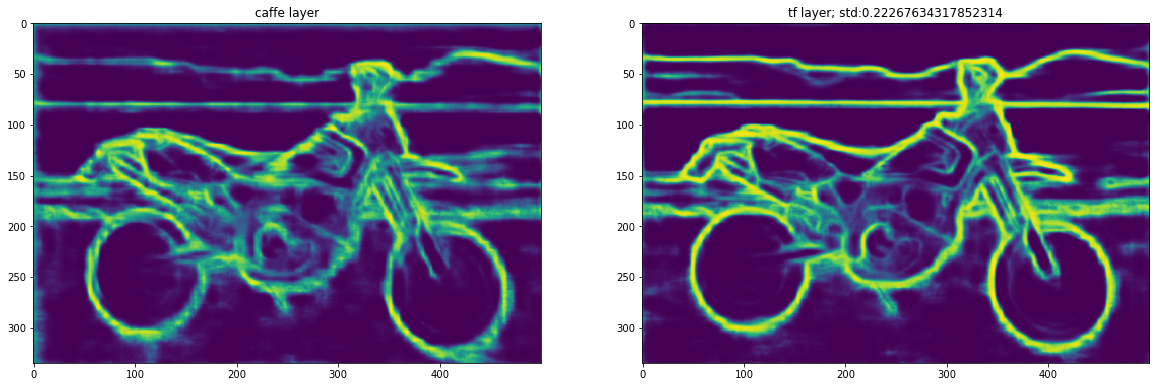

In [37]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(ff[:,:,0])
plt.title('caffe layer')
plt.subplot(1,2,2)

plt.imshow(l_out[:,:,0])
plt.title('tf layer; std:{}'.format(np.mean((ff-l_out)**2)**0.5))

# Caffe section

In [38]:
import caffe
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

base=r'/home/sgr/COB/models'
PRETRAINED = '{0}/COB_PASCALContext_trainval.caffemodel'.format(base)
MODEL_FILE = '{0}/deploy.prototxt'.format(base)

img = np.asarray(Image.open(r'/home/sgr/Загрузки/COB/demos/2010_005731.png'))

net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
caffe.set_mode_cpu()

counter=0
for key in net.params:    
    num=net.params[key].__len__()
    out='{0:22}#{1:2}'.format(key, num)
    
    for i in range(num):
        sh=net.params[key][i].data[...].shape
#         out='{0}; {1:3} shape:{2:25}'.format(out, i, sh)
        out='{0};\t{1}: shape:{2:20}'.format(out, i+1, str(sh))
    counter+=1
    print(out)
print('Total params layer: '+str(counter))

conv1                 # 2;	1: shape:(64, 3, 7, 7)       ;	2: shape:(64,)               
res2a_branch1         # 1;	1: shape:(256, 64, 1, 1)     
res2a_branch2a        # 1;	1: shape:(64, 64, 1, 1)      
res2a_branch2b        # 1;	1: shape:(64, 64, 3, 3)      
res2a_branch2c        # 1;	1: shape:(256, 64, 1, 1)     
res2b_branch2a        # 1;	1: shape:(64, 256, 1, 1)     
res2b_branch2b        # 1;	1: shape:(64, 64, 3, 3)      
res2b_branch2c        # 1;	1: shape:(256, 64, 1, 1)     
res2c_branch2a        # 1;	1: shape:(64, 256, 1, 1)     
res2c_branch2b        # 1;	1: shape:(64, 64, 3, 3)      
res2c_branch2c        # 1;	1: shape:(256, 64, 1, 1)     
res3a_branch1         # 1;	1: shape:(512, 256, 1, 1)    
res3a_branch2a        # 1;	1: shape:(128, 256, 1, 1)    
res3a_branch2b        # 1;	1: shape:(128, 128, 3, 3)    
res3a_branch2c        # 1;	1: shape:(512, 128, 1, 1)    
res3b_branch2a        # 1;	1: shape:(128, 512, 1, 1)    
res3b_branch2b        # 1;	1: shape:(128, 128, 3, 3)    


In [6]:
mn=np.array([122.67891434, 116.66876762,104.00698793])
data=(img-mn)[:,:,[2,1,0]]
# data=np.transpose(data,axes=(1,0,2))
data=np.transpose(data,axes=(2,1,0))
# print([*data.shape])
net.blobs['data'].reshape(1, *data.shape)
net.blobs['data'].data[...]=data
res = net.forward()